In [11]:
import csv
import re
import matplotlib.pyplot as plt
import pandas as pd
from os import walk
from os.path import join
from io import StringIO

%matplotlib inline

# Directory where all the .out files are stored
directory = r'../to/the/directory/that/has/all/the/out/files'

# Get a list of all of the files in the directory
f = []
for (dirpath, dirnames, filenames) in walk(directory):
    f.extend(filenames)
    break

# Only keep the .out files
outlist = [x for x in f if x[-3:].upper() == 'OUT']

In [12]:
# Get S and I Reg columns from each file

# This is the text that precedes the data in every file
start = '   S          J EXP       ERROR       J REG       I REG\n\n   '
end = '\n\n           ####      Real Space Data                               ####\n\n'

# Column names
headers = ['S', 'J_EXP', 'ERROR', 'J_REG', 'I_REG']

# Loop through each .out file
for outfile in outlist:
    
    # Get the data from the file
    x = open(join(directory, outfile), 'r')
    
    # Get the text from the file
    text = x.read()
    
    # Get dmax for file name
    dmax = float(re.search('Maximum characteristic size:\W*(\d*\.\d*)', text).group(1))
    
    # Get the location of the data within the text
    idx1 = text.find(start)
    idx2 = text.find(end)
    
    # Remove unnecessary text and put into StringIO object for reading into a table
    testdata = StringIO(text[idx1+len(start):idx2].replace('            ',',').replace(',','   '))
    
    # Read the data into a table
    df = (pd.read_csv(testdata, names=headers, sep="\s\s(\s|-)", engine='python')
            .reset_index())
    df = df.loc[:, ((df!=' ').sum(axis=0) > 10)]
    df.columns = headers
    
    # Write to txt file
    df[['S', 'I_REG']].to_csv('{}_Prfit.txt'.format(re.search('i(.*)\.out', outfile).group(1),
                                                       dmax),
                              header=None, index=None, sep=' ')
    
    # Close the file
    x.close()    

In [13]:
# Extract some random info from files

# Create blank list to store all rows
all_list = [['OUT_name', 'Dmax', 'angular range', 'Real space Rg',
             'Real Space I(0)', 'alpha', 'total estimate']]

# Loop through each .out file
for outfile in outlist:
    
    # Get the data from the file
    x = open(join(directory, outfile), 'r')
    
    # Get the text from the file
    text = x.read()
    
    # Extract info from text
    dmax = float(re.search('Maximum characteristic size:\W*(\d*\.\d*)', text).group(1))
    angrange = re.search('Angular range:\W*(\d*\.\d*\W*to\W*\d*\.\d*)', text).group(1)
    realrg = re.search('Real space Rg:\W*(\d*.*)\n', text).group(1)
    realio = re.search('Real space I\(0\):\W*(\d*.*)\n', text).group(1)
    alpha = float(re.search('Current ALPHA:\W*(\d*.*)\n', text).group(1))
    totalest = float(re.search('Total Estimate:\W*(\d*\.\d*)', text).group(1))
    
    # Add to list 
    all_list.append([outfile, dmax, angrange, realrg, realio, alpha, totalest])

In [14]:
# CSV file to write the extracted info to
with open("output.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerows(all_list)

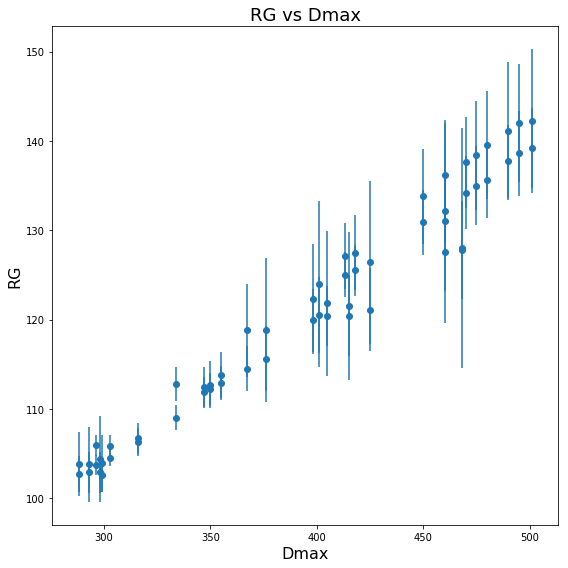

In [15]:
# Get plot of rg vs dmax

# Get data from all_list
dmax = [x[1] for x in all_list[1:]]
rg = [float(re.search('^(.*) \+\-', x[3]).group(1)) for x in all_list[1:]]
rgerr = [2.0*float(re.search('\+\-.* (\d.*)$', x[3]).group(1)) for x in all_list[1:]]

# Create plot canvas and size
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

# Add data to plot canvas
ax.errorbar(dmax, rg, yerr=rgerr, fmt="none")
ax.scatter(dmax, rg)

# Plot parameters
ax.set_title('RG vs Dmax', fontsize=18);
plt.xlabel('Dmax', fontsize=16)
plt.ylabel('RG', fontsize=16)
plt.tight_layout()